Installing tfds (tensorflow dataset) :

In [2]:
!pip install -q tfds-nightly
!tfds --version

2020-12-08 09:09:03.253243: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
TensorFlow Datasets: 4.1.0+nightly


Clone the source repo from GitHub

In [3]:
!git clone "https://github.com/heolfief/Where_is_Waldo_AI_solver.git"

Cloning into 'Where_is_Waldo_AI_solver'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 63 (delta 17), reused 38 (delta 5), pack-reused 0
Unpacking objects: 100% (63/63), done.


Create the images for the dataset

In [4]:
!python Where_is_Waldo_AI_solver/scripts/image_cutter.py

Warning, the following process may be quite long
100% 18/18 [02:18<00:00,  7.69s/it]


Building the dataset from the python script:

In [5]:
!tfds build Where_is_Waldo_AI_solver/scripts/create_TFDS.py --overwrite

2020-12-08 09:11:27.868509: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-12-08 09:11:29.864292: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2020-12-08 09:11:29.944966: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
I1208 09:11:30.025568 140421227362176 build.py:345] download_and_prepare for dataset waldo_dataset/1.0.0...
I1208 09:11:30.027696 140421227362176 dataset_builder.py:393] Generating dataset waldo_dataset (/root/tensorflow_datasets/waldo_dataset/1.0.0)
2020-12-08 09:11:30.085868: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
202

Testing the dataset :

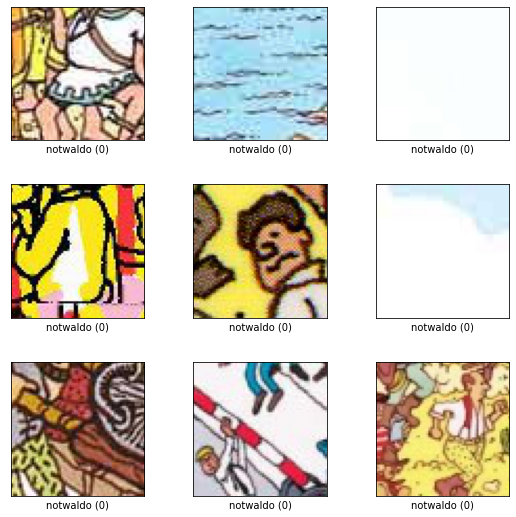

In [14]:
import tensorflow_datasets as tfds
ds, ds_info = tfds.load('waldo_dataset', split='train', with_info=True,  shuffle_files=True, as_supervised=True)
fig = tfds.show_examples(ds, ds_info)


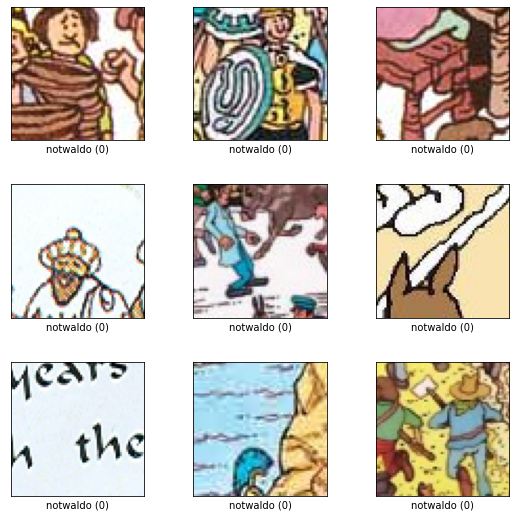

In [19]:
train_size = int(0.7 * ds_info.dataset_size)
val_size = int(0.15 * ds_info.dataset_size)
test_size = int(0.15 * ds_info.dataset_size)


ds = ds.shuffle(1000)
train_dataset = ds.take(train_size)
test_dataset = ds.skip(train_size)
val_dataset = ds.skip(val_size)
test_dataset = ds.take(test_size)

fig = tfds.show_examples(ds, ds_info)


**Build CNN :**

In the menu "Execution" -> modify execution type and select GPU. Once execution type is correctly configured, the GPU model should appaers below 

In [20]:
import tensorflow as tf
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14542237206917720127, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12242276903969762258
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2449259854065363347
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15695549568
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3618960641477149950
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

Load dataset in a dataset class :

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dropout,Flatten
import time

train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.batch(128)
test_dataset = test_dataset.shuffle(1000)
test_dataset = test_dataset.batch(128)

In [24]:
CNN = Sequential()
CNN.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(64,64,3)))
CNN.add(MaxPooling2D(pool_size=(2, 2)))

CNN.add(Conv2D(32, (5, 5), activation='relu'))
CNN.add(MaxPooling2D(pool_size=(2, 2)))

CNN.add(Flatten())
# add 3 hiden layers 
# TO DO
CNN.add(Dense(units=2, activation='softmax'))
#CNN.add(Dense(units=84, activation='tanh'))
#CNN.add(Dense(units=10, activation='softmax'))

CNN.summary()

CNN.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)



CNN.fit(train_dataset, epochs=6, validation_data=test_dataset)


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 60, 60, 32)        2432      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 26, 26, 32)        25632     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 10818     
Total params: 38,882
Trainable params: 38,882
Non-trainable params: 0
__________________________________________________

In [ ]:

print("Evaluate on test data")
results = CNN.evaluate(test_dataset)
print("test loss, test acc:", results)

Evaluate on test data
 447/1322 [=========>....................] - ETA: 28s - loss: 0.0036 - accuracy: 0.9996